# INSY662 - Group Project - Predicting Airline Fares

### Problem Definition and Motivation



### Dataset Description 


### Initial Processing Steps

In [92]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import re

# Load dataset in folder Data 
df = pd.read_csv('../data/processed_data.csv')
df.head()

# keep only 20% of rows 
data = df.sample(frac=0.05, random_state=42)




In [93]:
# 1) Check data types 
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 205347 entries, 1042959 to 1887118
Data columns (total 27 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   legId                              205347 non-null  object 
 1   searchDate                         205347 non-null  object 
 2   flightDate                         205347 non-null  object 
 3   startingAirport                    205347 non-null  object 
 4   destinationAirport                 205347 non-null  object 
 5   fareBasisCode                      205347 non-null  object 
 6   travelDuration                     205347 non-null  object 
 7   elapsedDays                        205347 non-null  int64  
 8   isBasicEconomy                     205347 non-null  bool   
 9   isRefundable                       205347 non-null  bool   
 10  isNonStop                          205347 non-null  bool   
 11  baseFare                           20

In [94]:
# Chekck missing values
data.isnull().sum()

legId                                    0
searchDate                               0
flightDate                               0
startingAirport                          0
destinationAirport                       0
fareBasisCode                            0
travelDuration                           0
elapsedDays                              0
isBasicEconomy                           0
isRefundable                             0
isNonStop                                0
baseFare                                 0
totalFare                                0
seatsRemaining                           0
totalTravelDistance                  15255
segmentsDepartureTimeEpochSeconds        0
segmentsDepartureTimeRaw                 0
segmentsArrivalTimeEpochSeconds          0
segmentsArrivalTimeRaw                   0
segmentsArrivalAirportCode               0
segmentsDepartureAirportCode             0
segmentsAirlineName                      0
segmentsAirlineCode                      0
segmentsEqu

In [95]:
# Missing value Ration
missing_ratio = data.isnull().sum() / len(data) * 100
missing_ratio = missing_ratio[missing_ratio > 0].sort_values(ascending=False)
missing_ratio

totalTravelDistance             7.428889
segmentsEquipmentDescription    1.905555
segmentsDistance                1.023633
dtype: float64

In [96]:
# ---------- Find dupplicates ----------------
dupplicates = data[data.duplicated()]
ratio = len(dupplicates) / len(data) * 100
print(f"There are {len(dupplicates)} out of {len(data)} rows, representing {ratio:.2f}%")

# Ratio is low, drop
data = data.drop_duplicates()
dupplicates = data[data.duplicated()]
ratio = len(dupplicates) / len(data) * 100
print(f"There are {len(dupplicates)} out of {len(data)} rows, representing {ratio:.2f}%")


There are 256 out of 205347 rows, representing 0.12%
There are 0 out of 205091 rows, representing 0.00%


#### Data Cleaning

In [97]:
# ------Drop unecessary segment columns---------
# Reasons: redundent information or not relevant to objective of analysis
unecessary_col = ['segmentsDepartureTimeEpochSeconds', 'segmentsArrivalTimeEpochSeconds', 'segmentsAirlineCode', 
                  'segmentsEquipmentDescription', 'segmentsEquipmentDescription', 'fareBasisCode', 'segmentsDurationInSeconds', 'segmentsDistance']
data = data.drop(columns = unecessary_col)


In [98]:
data.head()

,legId,searchDate,flightDate,startingAirport,destinationAirport,travelDuration,elapsedDays,isBasicEconomy,isRefundable,isNonStop,baseFare,totalFare,seatsRemaining,totalTravelDistance,segmentsDepartureTimeRaw,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsCabinCode
1042959,476b78efd396326a49ab6c014062580d,2022-06-05,2022-06-08,BOS,OAK,PT17H51M,0,False,False,False,740.47,829.71,9,2945.0,2022-06-08T07:30:00.000-04:00||2022-06-08T15:4...,2022-06-08T09:20:00.000-05:00||2022-06-08T17:5...,ORD||LAX||OAK,BOS||ORD||LAX,United||United||Delta,coach||coach||coach
1437841,f51769cb2653b33e5cfa08c03f807e60,2022-06-23,2022-06-29,DFW,DTW,PT2H41M,0,False,False,True,339.53,379.60,6,995.0,2022-06-29T18:39:00.000-05:00,2022-06-29T22:20:00.000-04:00,DTW,DFW,Delta,coach
1067453,70a386ff829092750869136b4c710568,2022-06-08,2022-06-14,LAX,CLT,PT10H59M,0,False,False,False,626.98,702.10,1,2275.0,2022-06-14T08:20:00.000-07:00||2022-06-14T16:4...,2022-06-14T13:25:00.000-05:00||2022-06-14T20:0...,AUS||ATL||CLT,LAX||AUS||ATL,Alaska Airlines||Delta||Delta,coach||coach||coach
198386,15a2d8dc5cb7b3ec0210f1f87adcbade,2022-04-23,2022-06-12,IAD,LAX,PT14H50M,0,False,False,False,556.28,627.20,7,2679.0,2022-06-12T07:33:00.000-04:00||2022-06-12T16:1...,2022-06-12T08:50:00.000-04:00||2022-06-12T19:2...,EWR||LAX,IAD||EWR,United||Alaska Airlines,coach||coach
2674967,5a26f39498d66b0836491c0aebb4f080,2022-08-07,2022-09-06,JFK,DEN,PT8H43M,0,False,False,False,537.67,601.60,9,1694.0,2022-09-06T11:22:00.000-04:00||2022-09-06T16:0...,2022-09-06T12:48:00.000-04:00||2022-09-06T18:0...,DCA||DEN,JFK||DCA,Delta||United,coach||coach


In [99]:
data.columns.tolist()

['legId',
 'searchDate',
 'flightDate',
 'startingAirport',
 'destinationAirport',
 'travelDuration',
 'elapsedDays',
 'isBasicEconomy',
 'isRefundable',
 'isNonStop',
 'baseFare',
 'totalFare',
 'seatsRemaining',
 'totalTravelDistance',
 'segmentsDepartureTimeRaw',
 'segmentsArrivalTimeRaw',
 'segmentsArrivalAirportCode',
 'segmentsDepartureAirportCode',
 'segmentsAirlineName',
 'segmentsCabinCode']

In [100]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 205091 entries, 1042959 to 1887118
Data columns (total 20 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   legId                         205091 non-null  object 
 1   searchDate                    205091 non-null  object 
 2   flightDate                    205091 non-null  object 
 3   startingAirport               205091 non-null  object 
 4   destinationAirport            205091 non-null  object 
 5   travelDuration                205091 non-null  object 
 6   elapsedDays                   205091 non-null  int64  
 7   isBasicEconomy                205091 non-null  bool   
 8   isRefundable                  205091 non-null  bool   
 9   isNonStop                     205091 non-null  bool   
 10  baseFare                      205091 non-null  float64
 11  totalFare                     205091 non-null  float64
 12  seatsRemaining                205091 non-n

In [101]:

SEP = '||'

# Extract first departure and last arrival
dep_first_raw = (
    data['segmentsDepartureTimeRaw']
    .astype(str)
    .str.split(SEP, regex=False)
    .str.get(0)
    .str.strip()
)

arr_last_raw = (
    data['segmentsArrivalTimeRaw']
    .astype(str)
    .str.split(SEP, regex=False)
    .str.get(-1)
    .str.strip()
)

# Convert to proper datetimes (with timezone handling)
dep_dt = pd.to_datetime(dep_first_raw, utc=True, errors='coerce')
arr_dt = pd.to_datetime(arr_last_raw,  utc=True, errors='coerce')

# Extract only the time part (HH:MM:SS)
data['itineraryDeparture_time'] = dep_dt.dt.time
data['itineraryArrival_time']   = arr_dt.dt.time
data = data.drop(columns = ['segmentsDepartureTimeRaw', 'segmentsArrivalTimeRaw' ])


In [102]:
data.head()

,legId,searchDate,flightDate,startingAirport,destinationAirport,travelDuration,elapsedDays,isBasicEconomy,isRefundable,isNonStop,baseFare,totalFare,seatsRemaining,totalTravelDistance,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsCabinCode,itineraryDeparture_time,itineraryArrival_time
1042959,476b78efd396326a49ab6c014062580d,2022-06-05,2022-06-08,BOS,OAK,PT17H51M,0,False,False,False,740.47,829.71,9,2945.0,ORD||LAX||OAK,BOS||ORD||LAX,United||United||Delta,coach||coach||coach,11:30:00,05:21:00
1437841,f51769cb2653b33e5cfa08c03f807e60,2022-06-23,2022-06-29,DFW,DTW,PT2H41M,0,False,False,True,339.53,379.60,6,995.0,DTW,DFW,Delta,coach,23:39:00,02:20:00
1067453,70a386ff829092750869136b4c710568,2022-06-08,2022-06-14,LAX,CLT,PT10H59M,0,False,False,False,626.98,702.10,1,2275.0,AUS||ATL||CLT,LAX||AUS||ATL,Alaska Airlines||Delta||Delta,coach||coach||coach,15:20:00,02:19:00
198386,15a2d8dc5cb7b3ec0210f1f87adcbade,2022-04-23,2022-06-12,IAD,LAX,PT14H50M,0,False,False,False,556.28,627.20,7,2679.0,EWR||LAX,IAD||EWR,United||Alaska Airlines,coach||coach,11:33:00,02:23:00
2674967,5a26f39498d66b0836491c0aebb4f080,2022-08-07,2022-09-06,JFK,DEN,PT8H43M,0,False,False,False,537.67,601.60,9,1694.0,DCA||DEN,JFK||DCA,Delta||United,coach||coach,15:22:00,00:05:00


In [103]:
# ------------ Correct Data Types of Segments ----------------

# List segment columns
#segmentsTime_cols = [col for col in data.columns if "timeraw" in col.lower()]
#segmentsTime_cols
#
## Split columns per segment and drop original column
#for col in segmentsTime_cols:
#    split_cols = data[col].str.split("||", expand=True, regex=False)
#    split_cols = split_cols.dropna(axis = 1, how = "all")
#    split_cols.columns = [f"{col}_{i+1}" for i in range(split_cols.shape[1])]
#    data = pd.concat([data, split_cols], axis = 1)
#    data = data.drop(columns = [col])

# List segment columns
#for col in segmentsTime_cols:
#    data[col] = pd.to_datetime(data[col], errors='coerce', utc=True)
#for c in segmentsTime_cols:
#    data[c] = data[c].dt.tz_localize(None)

# segmentsNumerical_cols = [col for col in data.columns if "seconds" in col.lower() or "distance" in col.lower()]
# for col in segmentsNumerical_cols:
#     data[col] = pd.to_numeric(data[col], errors='coerce').astype('Int64')


In [104]:
# ---------Clean Other DataTypes----------------

# Transfrom data columns into correct data types
data['searchDate'] = pd.to_datetime(data['searchDate'])
data['flightDate'] = pd.to_datetime(data['flightDate'])






In [105]:
#------------- Clean Travel Duration column --------------
def parse_travel_duration(s):
    if pd.isnull(s):
        return None
    
    # ISO 8601 duration pattern (supports P1D, P2W, PT5H30M, etc.)
    pattern = (
        r'P'                            # starts with P
        r'(?:(\d+)D)?'                  # days
        r'(?:(\d+)W)?'                  # weeks
        r'(?:T(?:(\d+)H)?(?:(\d+)M)?)?' # time part (hours/minutes)
    )
    match = re.match(pattern, s)
    if not match:
        return None
    
    days = int(match.group(1)) if match.group(1) else 0
    weeks = int(match.group(2)) if match.group(2) else 0
    hours = int(match.group(3)) if match.group(3) else 0
    minutes = int(match.group(4)) if match.group(4) else 0

    total_hours = weeks * 7 * 24 + days * 24 + hours + minutes / 60
    return total_hours

# Apply it
data['travelDuration_hours'] = data['travelDuration'].apply(parse_travel_duration)
data = data.drop(columns='travelDuration')






In [106]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 205091 entries, 1042959 to 1887118
Data columns (total 20 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   legId                         205091 non-null  object        
 1   searchDate                    205091 non-null  datetime64[ns]
 2   flightDate                    205091 non-null  datetime64[ns]
 3   startingAirport               205091 non-null  object        
 4   destinationAirport            205091 non-null  object        
 5   elapsedDays                   205091 non-null  int64         
 6   isBasicEconomy                205091 non-null  bool          
 7   isRefundable                  205091 non-null  bool          
 8   isNonStop                     205091 non-null  bool          
 9   baseFare                      205091 non-null  float64       
 10  totalFare                     205091 non-null  float64       
 11  seatsRemain

In [107]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 205091 entries, 1042959 to 1887118
Data columns (total 20 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   legId                         205091 non-null  object        
 1   searchDate                    205091 non-null  datetime64[ns]
 2   flightDate                    205091 non-null  datetime64[ns]
 3   startingAirport               205091 non-null  object        
 4   destinationAirport            205091 non-null  object        
 5   elapsedDays                   205091 non-null  int64         
 6   isBasicEconomy                205091 non-null  bool          
 7   isRefundable                  205091 non-null  bool          
 8   isNonStop                     205091 non-null  bool          
 9   baseFare                      205091 non-null  float64       
 10  totalFare                     205091 non-null  float64       
 11  seatsRemain

In [108]:
data.describe()

,searchDate,flightDate,elapsedDays,baseFare,totalFare,seatsRemaining,totalTravelDistance,travelDuration_hours
count,205091,205091,205091.000000,205091.000000,205091.000000,205091.000000,189857.000000,205091.000000
mean,2022-07-13 21:37:43.254848,2022-08-09 17:48:12.150313472,0.149485,292.735894,340.451497,5.976601,1609.069184,7.139293
min,2022-04-16 00:00:00,2022-04-17 00:00:00,0.000000,0.410000,19.590000,0.000000,89.000000,0.766667
25%,2022-06-05 00:00:00,2022-07-01 00:00:00,0.000000,159.000000,197.100000,4.000000,876.000000,4.350000
50%,2022-07-16 00:00:00,2022-08-14 00:00:00,0.000000,259.530000,303.700000,7.000000,1464.000000,6.816667
75%,2022-08-23 00:00:00,2022-09-18 00:00:00,0.000000,398.140000,452.700000,9.000000,2417.000000,9.433333
max,2022-10-05 00:00:00,2022-11-19 00:00:00,2.000000,4407.440000,4752.600000,10.000000,4498.000000,35.000000
std,NaN,NaN,0.356608,183.484098,196.363650,2.878256,857.232738,3.759692


In [109]:
# Question: Handling Outliers

### Exploratory Data Analysis (EDA) results

In [110]:
# Look at numerical relatioships with Total Fare

import seaborn as sns
import matplotlib.pyplot as plt

def num_plotter(data, target):

    num_cols = data.select_dtypes(include=["int", "float"]).columns

    for col in num_cols:
        if col == target:
            continue  

        plt.figure(figsize=(6, 4))
        sns.scatterplot(x=col, y=target, data=data, alpha=0.3)
        plt.title(f"{col} vs {target}")
        plt.tight_layout()
        plt.show()


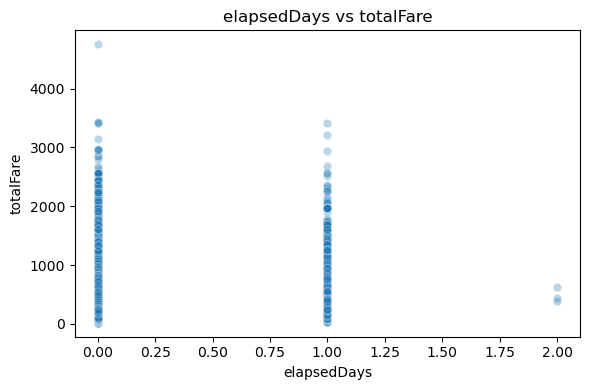

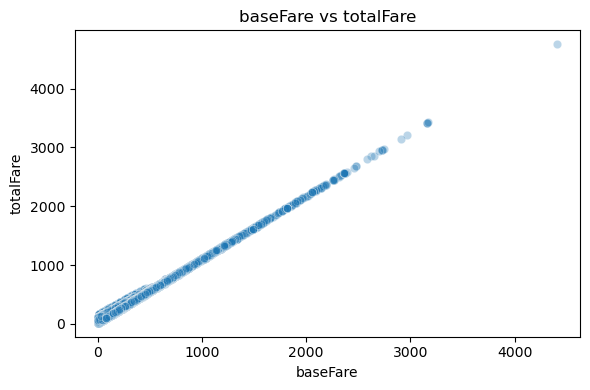

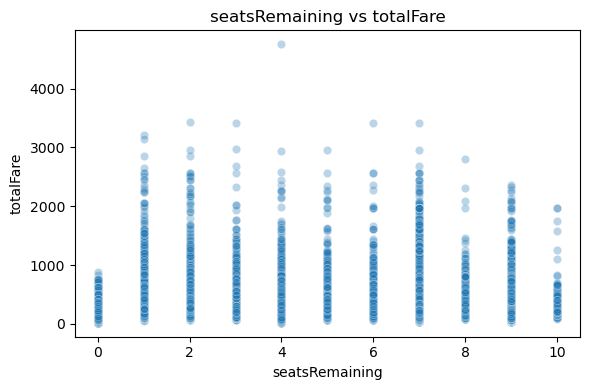

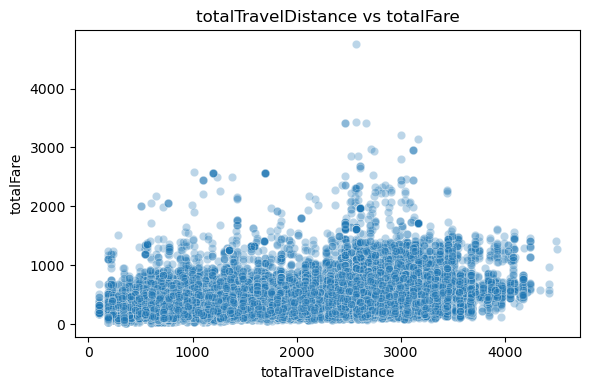

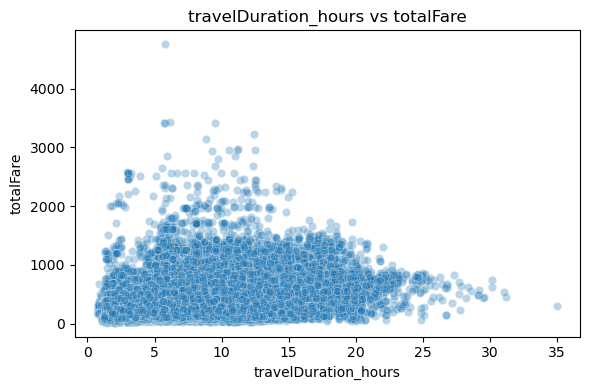

In [111]:
num_plotter(data, "totalFare")


In [112]:
# Look at categorical variable relationships with Total Fare
def cat_plotter(data, target, sample_size=100000):
    cat_cols = [
        'startingAirport',
        'destinationAirport'
    ]
    
    
    # 3. Plot
    for col in cat_cols:
        plt.figure(figsize=(8, 4))
        sns.barplot(
            data=(
                data
                .groupby(col, as_index=False)
                .agg({target: "mean"})
                .sort_values(by=target, ascending=False)
            ), 
            x=col, 
            y=target
        )
        plt.title(f"Average {target} by {col}")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    

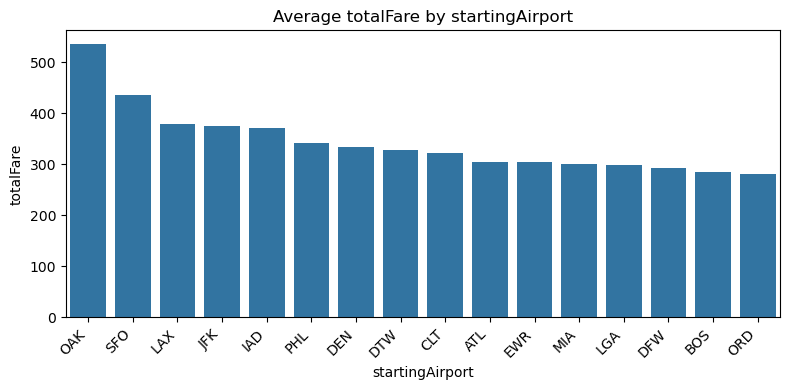

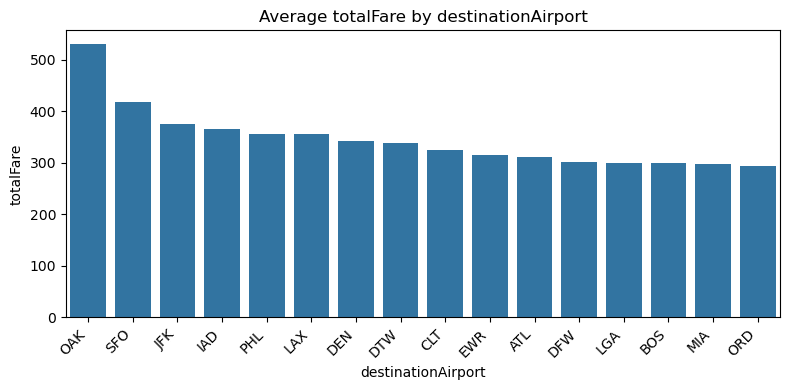

In [113]:
cat_plotter(data, "totalFare", sample_size=100000)


                      elapsedDays  baseFare  totalFare  seatsRemaining  \
elapsedDays              1.000000  0.135252   0.145732       -0.024762   
baseFare                 0.135252  1.000000   0.996711        0.059145   
totalFare                0.145732  0.996711   1.000000        0.020617   
seatsRemaining          -0.024762  0.059145   0.020617        1.000000   
totalTravelDistance      0.294933  0.486401   0.493158       -0.054751   
travelDuration_hours     0.384262  0.390699   0.427200       -0.149538   

                      totalTravelDistance  travelDuration_hours  
elapsedDays                      0.294933              0.384262  
baseFare                         0.486401              0.390699  
totalFare                        0.493158              0.427200  
seatsRemaining                  -0.054751             -0.149538  
totalTravelDistance              1.000000              0.708364  
travelDuration_hours             0.708364              1.000000  


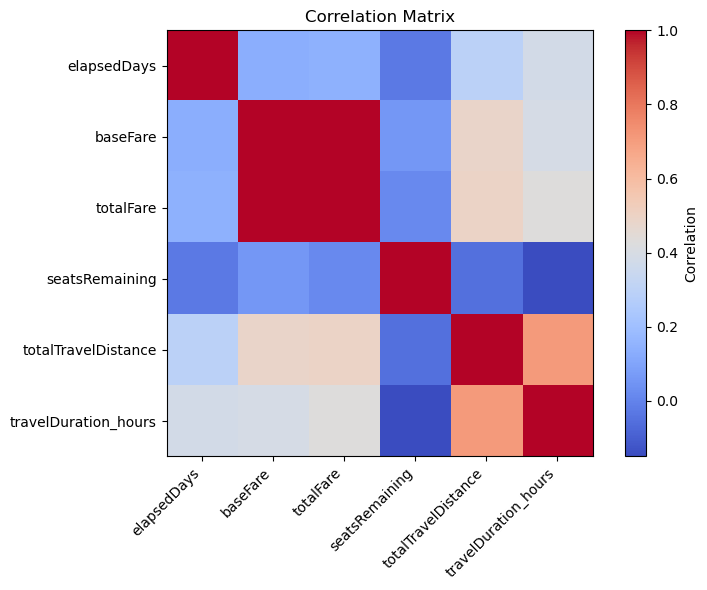

In [114]:
import matplotlib.pyplot as plt
import pandas as pd


# Select only numeric columns
num_df = data.select_dtypes(include=['number'])
# remove segment columns for clarity
num_df = num_df[[col for col in num_df.columns if 'segment' not in col.lower()]]


# Compute correlation matrix
corr = num_df.corr()

# Display top correlations
print(corr)

# Visualize (Matplotlib heatmap only)
plt.figure(figsize=(8,6))
plt.imshow(corr, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Correlation')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha='right')
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()


In [115]:
data = data.drop(columns = 'baseFare')

### Feature engineering steps

##### Scaling
##### Encoding
##### Binning
##### Transformations
##### Handling Outliers
##### Creation of Derived Variables

In [116]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [117]:
# Create new column for number of days between search date and flight date
data['date_diff'] = (data['flightDate'] - data['searchDate']).dt.days

In [118]:
# ------------- Clean/Split Segment Columns ---------------


# List segment columns
segments = [col for col in data.columns if "segment" in col.lower()]
segments

# Count number of connections
for col in segments:
    split_cols = data[col].str.split("||", expand=True, regex=False)

def count_connections(row):
    if isinstance(row, str):
        airlines = row.split('||')
        return len(set(airlines))
    return 0

data['num_connections'] = data['segmentsArrivalAirportCode'].apply(count_connections)

data['flight_arrivalDate'] = data['flightDate'] + pd.to_timedelta(data['elapsedDays'], unit='D')

#  day of the week for Flight and Search (monday=1, sunday=7)
data['flight_dayofweek'] = data['flightDate'].dt.dayofweek+1  
data['search_dayofweek'] = data['searchDate'].dt.dayofweek+1

# classify if flight is on weekend (1) or weekday (0)
data['is_weekend_flight'] = data['flight_dayofweek'].apply(lambda x: 1 if x in [5, 6] else 0)   

# add seasonality column: summer or not (April, May, September, October not summer)
data['is_summer'] = data['flightDate'].apply(
    lambda x: 1 if pd.notnull(x) and x.month in [6, 7, 8] else 0)

In [119]:
data.head()

,legId,searchDate,flightDate,startingAirport,destinationAirport,elapsedDays,isBasicEconomy,isRefundable,isNonStop,totalFare,...,itineraryDeparture_time,itineraryArrival_time,travelDuration_hours,date_diff,num_connections,flight_arrivalDate,flight_dayofweek,search_dayofweek,is_weekend_flight,is_summer
1042959,476b78efd396326a49ab6c014062580d,2022-06-05,2022-06-08,BOS,OAK,0,False,False,False,829.71,...,11:30:00,05:21:00,17.850000,3,3,2022-06-08,3,7,0,1
1437841,f51769cb2653b33e5cfa08c03f807e60,2022-06-23,2022-06-29,DFW,DTW,0,False,False,True,379.60,...,23:39:00,02:20:00,2.683333,6,1,2022-06-29,3,4,0,1
1067453,70a386ff829092750869136b4c710568,2022-06-08,2022-06-14,LAX,CLT,0,False,False,False,702.10,...,15:20:00,02:19:00,10.983333,6,3,2022-06-14,2,3,0,1
198386,15a2d8dc5cb7b3ec0210f1f87adcbade,2022-04-23,2022-06-12,IAD,LAX,0,False,False,False,627.20,...,11:33:00,02:23:00,14.833333,50,2,2022-06-12,7,6,0,1
2674967,5a26f39498d66b0836491c0aebb4f080,2022-08-07,2022-09-06,JFK,DEN,0,False,False,False,601.60,...,15:22:00,00:05:00,8.716667,30,2,2022-09-06,2,7,0,0


In [130]:
# Clean and convert departure time
data['itineraryDeparture_time'] = data['itineraryDeparture_time'].astype(str).str.strip()
data['departure_hour'] = pd.to_datetime(data['itineraryDeparture_time'], errors='coerce', format=None).dt.hour

# Clean and convert arrival time
data['itineraryArrival_time'] = data['itineraryArrival_time'].astype(str).str.strip()
data['arrival_hour'] = pd.to_datetime(data['itineraryArrival_time'], errors='coerce', format=None).dt.hour

# Check the results
print(data[['itineraryDeparture_time', 'departure_hour',
            'itineraryArrival_time', 'arrival_hour']].head())





/var/folders/23/8rs30vhx2l77dtdgxd1972nc0000gn/T/ipykernel_75747/2380577183.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['departure_hour'] = pd.to_datetime(data['itineraryDeparture_time'], errors='coerce', format=None).dt.hour
/var/folders/23/8rs30vhx2l77dtdgxd1972nc0000gn/T/ipykernel_75747/2380577183.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['arrival_hour'] = pd.to_datetime(data['itineraryArrival_time'], errors='coerce', format=None).dt.hour


        itineraryDeparture_time  departure_hour itineraryArrival_time  \
1042959                11:30:00              11              05:21:00   
1437841                23:39:00              23              02:20:00   
1067453                15:20:00              15              02:19:00   
198386                 11:33:00              11              02:23:00   
2674967                15:22:00              15              00:05:00   

         arrival_hour  
1042959             5  
1437841             2  
1067453             2  
198386              2  
2674967             0  


In [ ]:
# ------ Bining ---------

def bin_columns(df):
    # Make sure hours are numeric
    df['departure_hour'] = pd.to_numeric(df['departure_hour'], errors='coerce')
    df['arrival_hour'] = pd.to_numeric(df['arrival_hour'], errors='coerce')
    
    # Define bins edges and labels
    bins = [-1, 10, 12, 18, 23]  # Morning, Midday, Afternoon, Night
    labels = ['Morning', 'Midday', 'Afternoon', 'Night']
    
    # Bin departure and arrival hours
    df['itineraryDeparture_time_bin'] = pd.cut(df['departure_hour'], bins=bins, labels=labels)
    df['itineraryArrival_time_bin'] = pd.cut(df['arrival_hour'], bins=bins, labels=labels)
    
    # Other bins
    df['seatsRemaining_bin'] = pd.cut(df['seatsRemaining'], bins=[-1, 2, 5, 10], labels=['1-2', '3-5', '6-10'])
    
    df['travelDuration_hours_bin'] = pd.cut(df['travelDuration_hours'],
                                            bins=[-1, 3, 6, 12, float('inf')],
                                            labels=['<3h', '3-6h', '6-12h', '>12h'])
    
    df['totalTravelDistance_bin'] = pd.cut(df['totalTravelDistance'],
                                           bins=[-1, 500, 1000, 2000, float('inf')],
                                           labels=['<500', '500-1000', '1000-2000', '2000+'])
    
    return df

# Apply the function
data = bin_columns(data)



In [132]:
data.head()

,legId,searchDate,flightDate,startingAirport,destinationAirport,elapsedDays,isBasicEconomy,isRefundable,isNonStop,totalFare,...,search_dayofweek,is_weekend_flight,is_summer,departure_hour,itineraryDeparture_time_bin,seatsRemaining_bin,travelDuration_hours_bin,totalTravelDistance_bin,arrival_hour,itineraryArrival_time_bin
1042959,476b78efd396326a49ab6c014062580d,2022-06-05,2022-06-08,BOS,OAK,0,False,False,False,829.71,...,7,0,1,11,Midday,6-10,>12h,2000+,5,Morning
1437841,f51769cb2653b33e5cfa08c03f807e60,2022-06-23,2022-06-29,DFW,DTW,0,False,False,True,379.60,...,4,0,1,23,Night,6-10,<3h,500-1000,2,Morning
1067453,70a386ff829092750869136b4c710568,2022-06-08,2022-06-14,LAX,CLT,0,False,False,False,702.10,...,3,0,1,15,Afternoon,1-2,6-12h,2000+,2,Morning
198386,15a2d8dc5cb7b3ec0210f1f87adcbade,2022-04-23,2022-06-12,IAD,LAX,0,False,False,False,627.20,...,6,0,1,11,Midday,6-10,>12h,2000+,2,Morning
2674967,5a26f39498d66b0836491c0aebb4f080,2022-08-07,2022-09-06,JFK,DEN,0,False,False,False,601.60,...,7,0,0,15,Afternoon,6-10,6-12h,1000-2000,0,Morning


In [ ]:
# ----- Dropping intermediary columns --------
data = data.drop(columns=['departure_hour', 'arrival_hour'])

['legId',
 'searchDate',
 'flightDate',
 'startingAirport',
 'destinationAirport',
 'elapsedDays',
 'isBasicEconomy',
 'isRefundable',
 'isNonStop',
 'totalFare',
 'seatsRemaining',
 'totalTravelDistance',
 'segmentsArrivalAirportCode',
 'segmentsDepartureAirportCode',
 'segmentsAirlineName',
 'segmentsCabinCode',
 'itineraryDeparture_time',
 'itineraryArrival_time',
 'travelDuration_hours',
 'date_diff',
 'num_connections',
 'flight_arrivalDate',
 'flight_dayofweek',
 'search_dayofweek',
 'is_weekend_flight',
 'is_summer',
 'itineraryDeparture_time_bin',
 'seatsRemaining_bin',
 'travelDuration_hours_bin',
 'totalTravelDistance_bin',
 'itineraryArrival_time_bin']

In [135]:
# ------- Scaling ------

num_col = data.select_dtypes(['int64', 'float64', 'Int64']).columns.tolist()

X = data[num_col]
y = data['totalFare']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 2025)


In [136]:
std = StandardScaler()

X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)

In [137]:
# ----- Checing the categorical columns ------

categorical_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical columns based on dtype:")
print(categorical_cols)

Categorical columns based on dtype:
['legId', 'startingAirport', 'destinationAirport', 'segmentsArrivalAirportCode', 'segmentsDepartureAirportCode', 'segmentsAirlineName', 'segmentsCabinCode', 'itineraryDeparture_time', 'itineraryArrival_time', 'itineraryDeparture_time_bin', 'seatsRemaining_bin', 'travelDuration_hours_bin', 'totalTravelDistance_bin', 'itineraryArrival_time_bin']


In [138]:
# ------- Encoding ---------

cat_cols = [
    'startingAirport', 'destinationAirport',
    'segmentsArrivalAirportCode',
    'segmentsDepartureAirportCode', 
    'segmentsAirlineName', 
    'segmentsCabinCode', 'itineraryDeparture_time_bin', 'seatsRemaining_bin', 'travelDuration_hours_bin', 'totalTravelDistance_bin', 'itineraryArrival_time_bin'   
]
col_dummy = data[cat_cols]

eng_data = pd.get_dummies(col_dummy, drop_first=True)

eng_data.dtypes


startingAirport_BOS                    bool
startingAirport_CLT                    bool
startingAirport_DEN                    bool
startingAirport_DFW                    bool
startingAirport_DTW                    bool
                                       ... 
totalTravelDistance_bin_1000-2000      bool
totalTravelDistance_bin_2000+          bool
itineraryArrival_time_bin_Midday       bool
itineraryArrival_time_bin_Afternoon    bool
itineraryArrival_time_bin_Night        bool
Length: 6708, dtype: object

In [63]:
# ------ Transformations --------

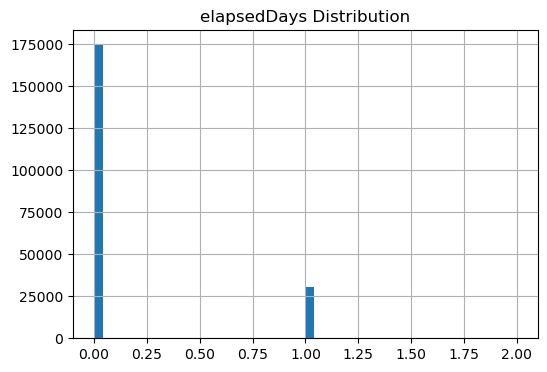

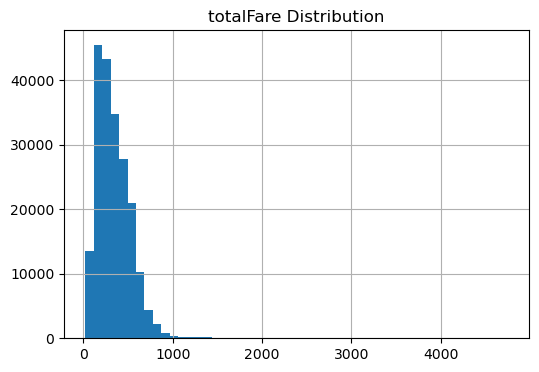

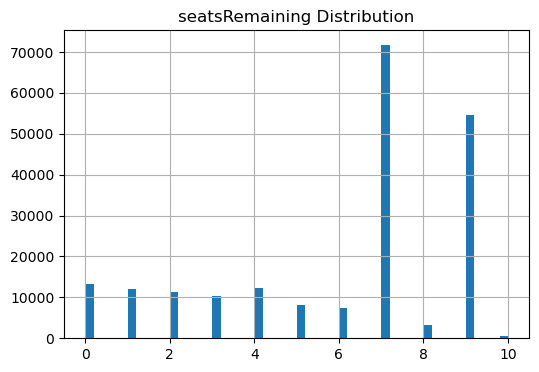

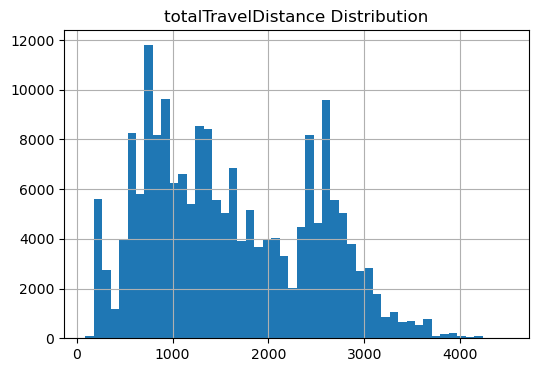

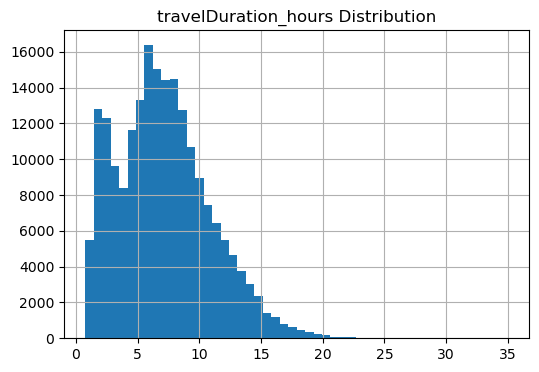

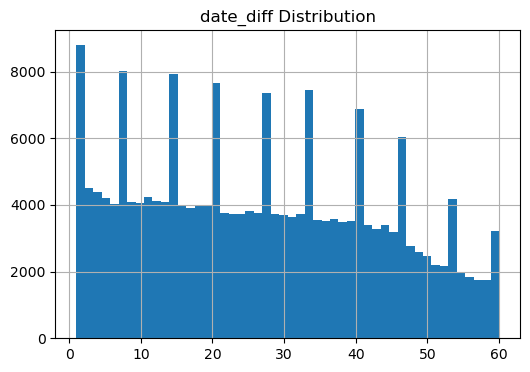

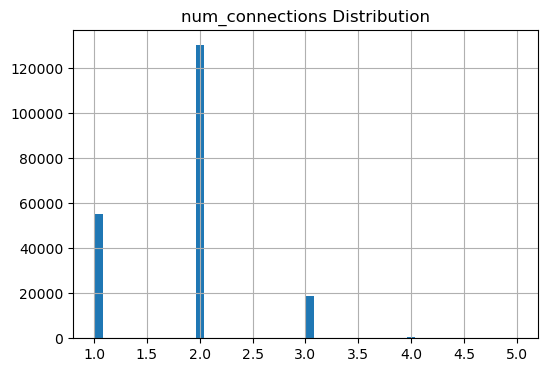

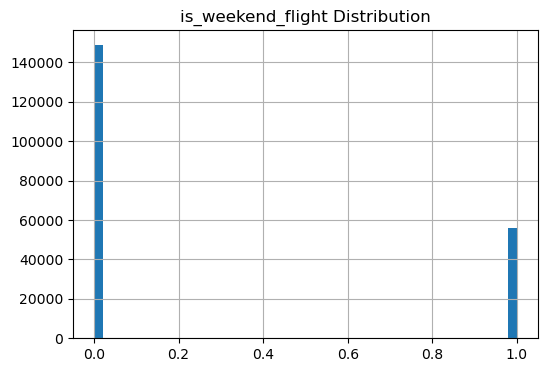

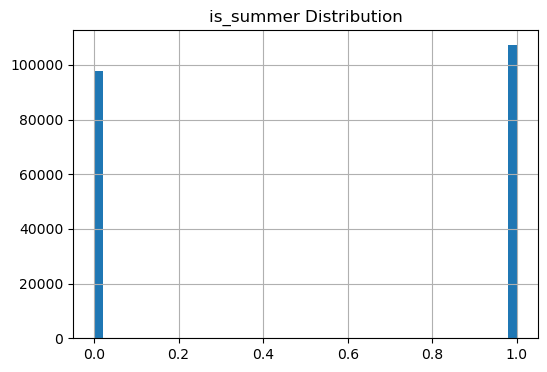

In [141]:
# ----- Checking for skewness of the numerical columns ------
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Plot histograms
for col in numerical_cols:
    plt.figure(figsize=(6,4))
    data[col].hist(bins=50)
    plt.title(f'{col} Distribution')
    plt.show()

In [142]:
# Checking if variables have 0 or negative values before applying log-transformations

log_cols = [
    'totalFare', 
    'travelDuration_hours'
]

# Check for zeros or negatives
for col in log_cols:
    min_val = data[col].min()
    num_nonpositive = (data[col] <= 0).sum()
    print(f"{col}: min = {min_val}, non-positive values = {num_nonpositive}")

totalFare: min = 19.59, non-positive values = 0
travelDuration_hours: min = 0.7666666666666667, non-positive values = 0


In [143]:
# ----- Log-Transformations --------

for col in log_cols:
    data[col] = data[col].astype(float)  
    data[f'log_{col}'] = np.log(data[col])  

print(data[[f'log_{col}' for col in log_cols]].head())


         log_totalFare  log_travelDuration_hours
1042959       6.721076                  2.882004
1437841       5.939118                  0.987060
1067453       6.554076                  2.396379
198386        6.441265                  2.696877
2674967       6.399593                  2.165237


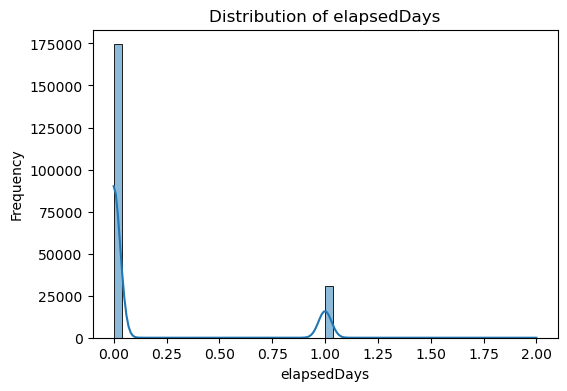

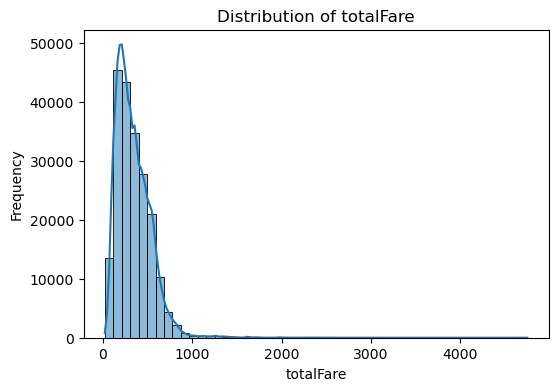

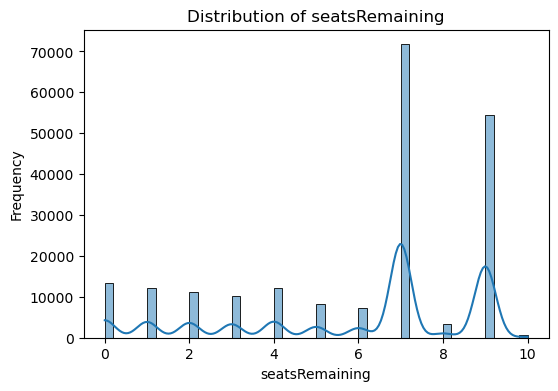

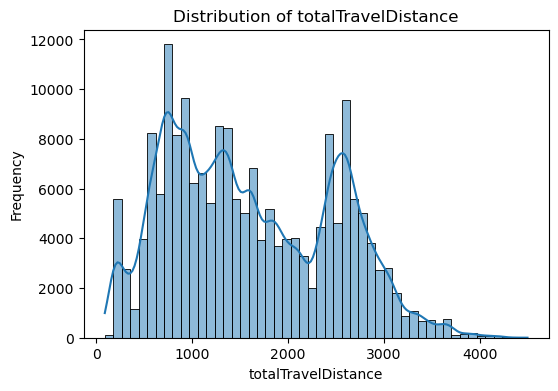

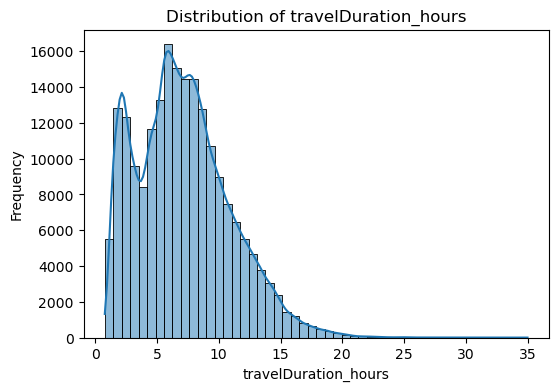

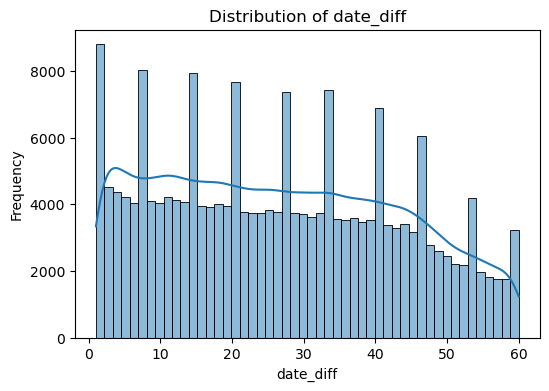

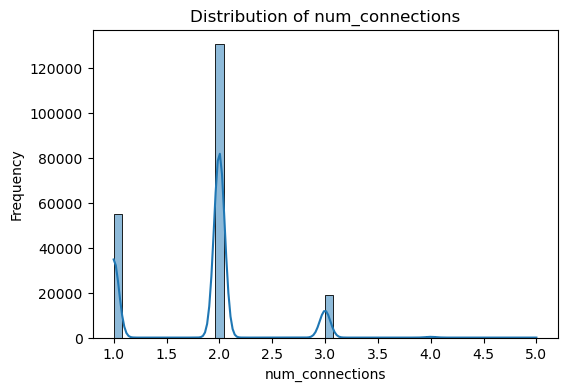

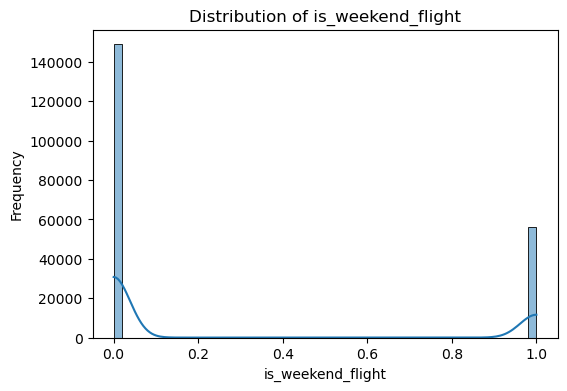

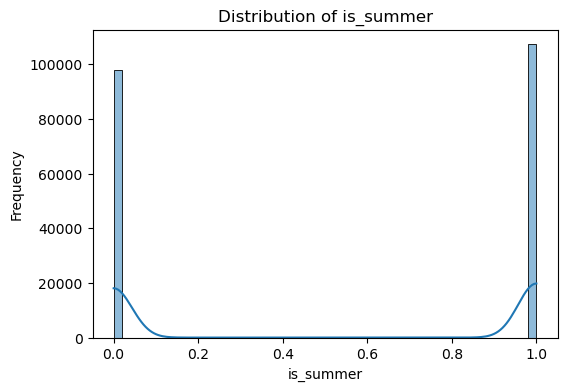

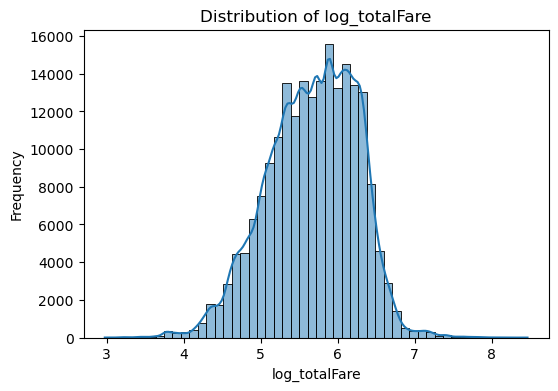

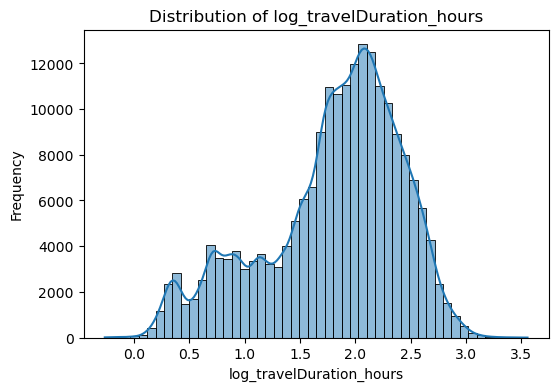

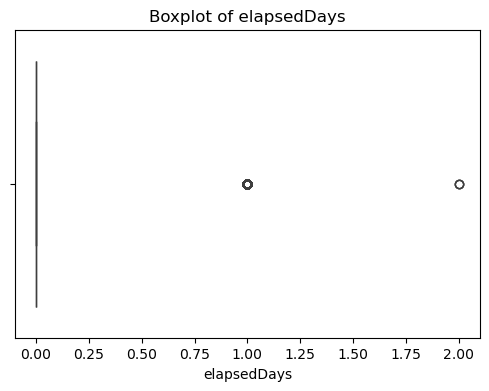

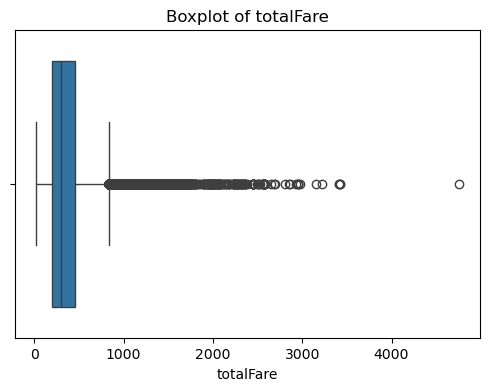

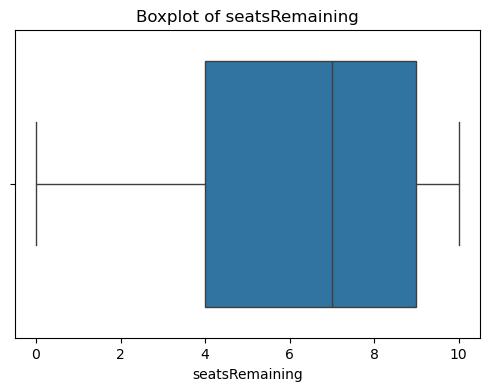

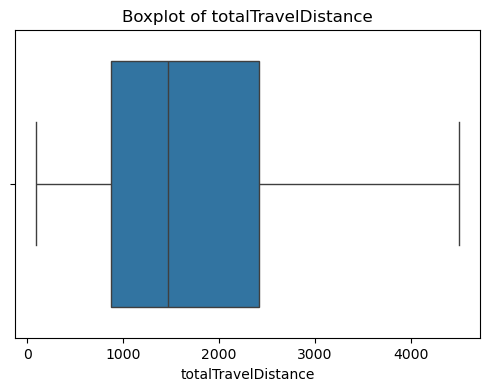

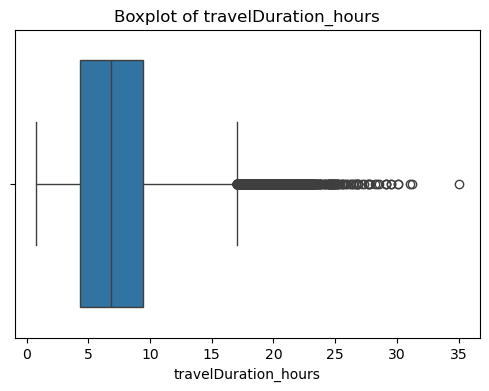

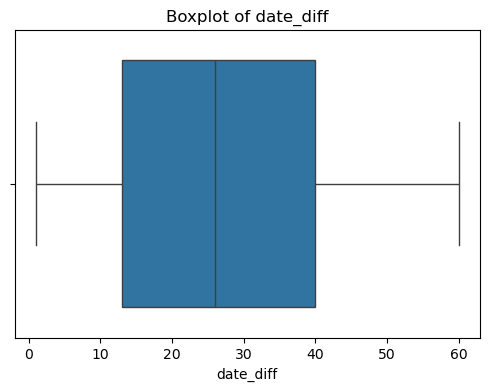

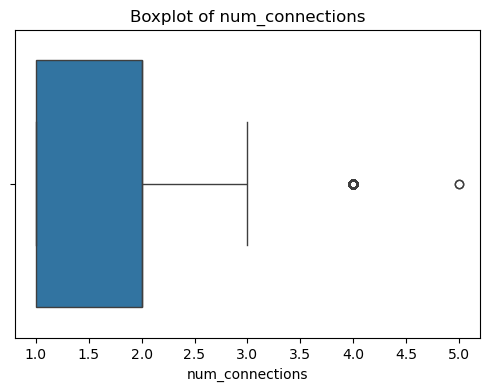

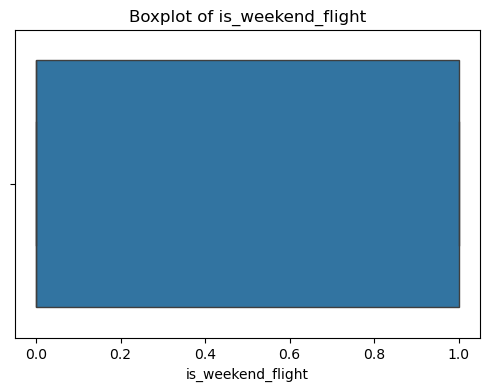

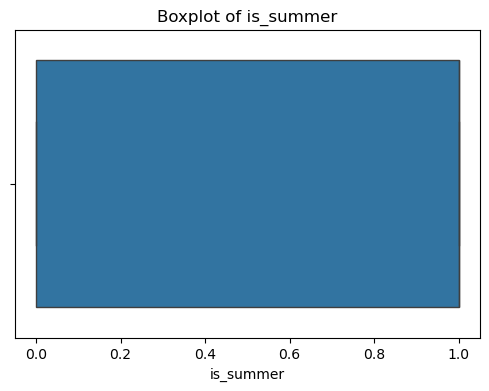

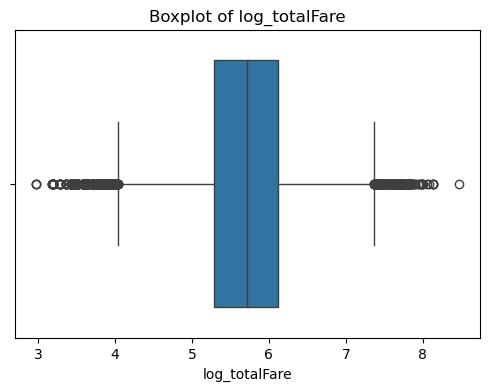

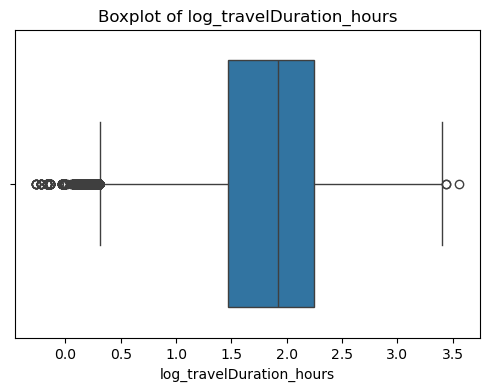

In [144]:
# -------- Handling Outliers ----------

# For integers 

num_col = data.select_dtypes(['int64', 'float64', 'Int64']).columns.tolist()

# Plot histograms for all numerical columns
for col in num_col:
    plt.figure(figsize=(6,4))
    sns.histplot(data[col], bins=50, kde=True)  # histogram + density
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# Optional: Boxplots to see outliers clearly
for col in num_col:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot of {col}')
    plt.show()


In [145]:
# for categorical variables
threshold = 0.10  
n_rows = len(data)

for col in cat_cols:
    freq = data[col].value_counts() / n_rows
    rare_categories = freq[freq < threshold]
    
    if len(rare_categories) > 0:
        print(f"{col}: {list(rare_categories.index)}")


startingAirport: ['LAX', 'LGA', 'BOS', 'DFW', 'SFO', 'ORD', 'CLT', 'ATL', 'MIA', 'PHL', 'DEN', 'DTW', 'JFK', 'EWR', 'OAK', 'IAD']
destinationAirport: ['LAX', 'LGA', 'DFW', 'BOS', 'ORD', 'SFO', 'CLT', 'ATL', 'MIA', 'PHL', 'DEN', 'DTW', 'JFK', 'EWR', 'OAK', 'IAD']
segmentsArrivalAirportCode: ['BOS', 'ORD', 'LGA', 'LAX', 'ATL', 'JFK', 'DFW', 'MIA', 'EWR', 'CLT', 'SFO', 'DEN', 'DTW', 'PHL', 'ORD||PHL', 'IAD', 'CLT||IAD', 'JFK||BOS', 'ORD||LGA', 'ATL||MIA', 'ATL||PHL', 'ORD||LAX', 'LAX||OAK', 'EWR||BOS', 'IAH||DFW', 'ATL||EWR', 'ATL||CLT', 'SEA||OAK', 'ATL||DAL', 'BOS||PHL', 'IAD||LGA', 'LAX||SFO', 'DFW||LAX', 'ORD||DTW', 'CLT||EWR', 'ORD||DEN', 'LAS||LAX', 'CLT||ATL', 'DCA||LGA', 'JFK||MIA', 'BOS||LGA', 'ATL||DFW', 'DCA||ORD', 'DFW||DEN', 'JFK||SFO', 'ATL||IAD', 'ATL||LGA', 'ORD||EWR', 'BOS||JFK', 'IAH||LAX', 'ORD||CLT', 'LGA||ORD', 'LAS||OAK', 'DFW||SFO', 'ORD||SFO', 'CLT||LGA', 'EWR||MIA', 'DCA||BOS', 'SEA||SFO', 'MCO||MIA', 'CLT||BOS', 'ORD||DFW', 'ATL||LAX', 'CLT||PHL', 'DFW||ONT', 'DC